<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Pfarelo_Yahoo_Finance_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import yfinance as yf
import pandas as pd
import seaborn as sns

def get_yahoo_finance_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data['Ticker'] = ticker
    return data

tickers = ["AAPL", "MSFT", "GOOGL"]
start_date = "2022-08-15"
end_date = "2024-08-15"

financial_data = pd.DataFrame()
for ticker in tickers:
    data = get_yahoo_finance_data(ticker, start_date, end_date)
    data['Text'] = "Closing price for " + ticker + " on " + data.index.strftime('%Y-%m-%d') + " was " + data['Close'].astype(str)
    financial_data = pd.concat([financial_data, data])

pd.set_option('display.max_rows', None)

print(financial_data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-08-15 00:00:00-04:00  169.640417  171.489920  169.472281  171.292114   
2022-08-16 00:00:00-04:00  170.886605  171.806421  169.778883  171.133865   
2022-08-17 00:00:00-04:00  170.876714  174.219664  170.678909  172.637207   
2022-08-18 00:00:00-04:00  171.845997  172.983389  171.222896  172.241608   
2022-08-19 00:00:00-04:00  171.133859  171.836085  169.432706  169.640411   
2022-08-22 00:00:00-04:00  167.830436  167.998571  165.308377  165.733673   
2022-08-23 00:00:00-04:00  165.249065  166.861208  164.823769  165.397415   
2022-08-24 00:00:00-04:00  165.486447  166.267784  164.428166  165.694138   
2022-08-25 00:00:00-04:00  166.930446  168.275543  166.505165  168.166748   
2022-08-26 00:00:00-04:00  168.700816  169.175552  161.767625  161.826965   
2022-08-29 00:00:00-04:00  159.384036  161.114859  158.068624  159.611526   

In [12]:
descriptive_stats = financial_data.groupby('Ticker')['Close'].describe()
print("Descriptive Statistics:\n", descriptive_stats)

Descriptive Statistics:
         count        mean        std         min         25%         50%  \
Ticker                                                                     
AAPL    503.0  172.940901  22.939588  123.855095  153.699112  173.323090   
GOOGL   503.0  127.699942  27.196848   83.334358  102.787033  128.932022   
MSFT    503.0  330.555878  70.650845  210.619064  259.626373  328.047882   

               75%         max  
Ticker                          
AAPL    188.373283  234.548523  
GOOGL   142.436523  191.179993  
MSFT    401.271637  466.718781  


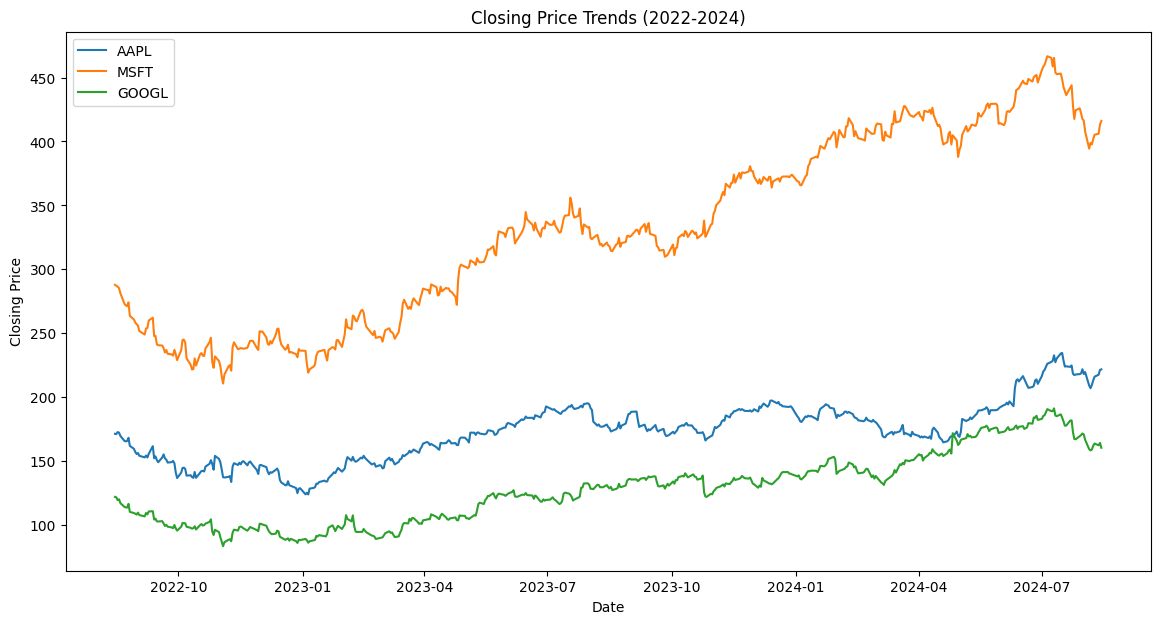

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(financial_data[financial_data['Ticker'] == ticker].index,
             financial_data[financial_data['Ticker'] == ticker]['Close'],
             label=ticker)

plt.title('Closing Price Trends (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [14]:
pivot_data = financial_data.pivot_table(values='Close', index=financial_data.index, columns='Ticker')

correlation_matrix = pivot_data.corr()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
 Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    1.000000  0.858651  0.855548
GOOGL   0.858651  1.000000  0.948132
MSFT    0.855548  0.948132  1.000000


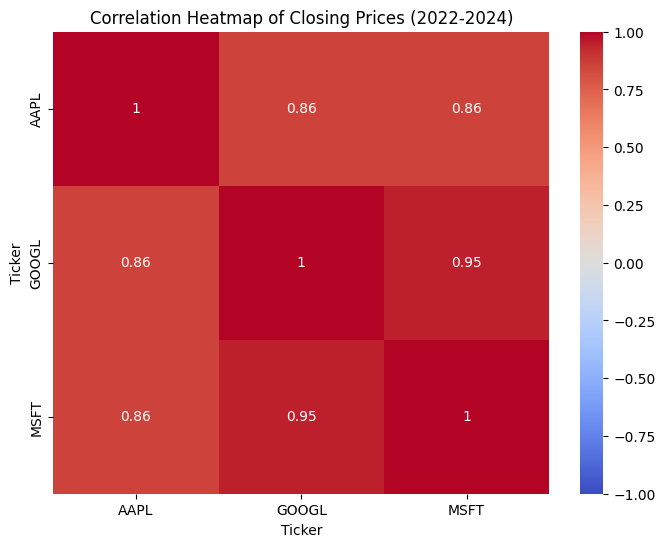

In [17]:
correlation_matrix = pivot_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Closing Prices (2022-2024)')
plt.show()

In [21]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

# Function to calculate d1 and d2
def calculate_d1_d2(V, D, r, sigma_V, T):
    d1 = (np.log(V / D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    return d1, d2

# Function to solve for asset value (V) and volatility (sigma_V)
def merton_model_solver(E, D, r, sigma_E, T):
    def equations(vars):
        V, sigma_V = vars
        d1, d2 = calculate_d1_d2(V, D, r, sigma_V, T)
        eq1 = E - (V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2))
        eq2 = sigma_E - (norm.cdf(d1) * sigma_V * V / E)
        return [eq1, eq2]

    V0 = E + D  # Initial guess for V
    sigma_V0 = sigma_E  # Initial guess for sigma_V
    V, sigma_V = fsolve(equations, [V0, sigma_V0])
    return V, sigma_V

# Function to calculate the Probability of Default (PD) using the Merton model
def calculate_pd(ticker, start_date, end_date, debt, risk_free_rate=0.03):
    # Fetch stock data
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)

    # Calculate market value of equity (latest close price * shares outstanding)
    E = stock_data['Close'].iloc[-1] * stock.info['sharesOutstanding']

    # Calculate annualized equity volatility (using daily returns)
    stock_data['Returns'] = stock_data['Close'].pct_change()
    sigma_E = stock_data['Returns'].std() * np.sqrt(252)  # Annualize the volatility

    # Assume a 1-year time horizon (T)
    T = 1

    # Estimate asset value (V) and volatility (sigma_V) using Merton model solver
    V, sigma_V = merton_model_solver(E, debt, risk_free_rate, sigma_E, T)

    # Calculate d1 and d2
    d1, d2 = calculate_d1_d2(V, debt, risk_free_rate, sigma_V, T)

    # Calculate Probability of Default (PD)
    PD = norm.cdf(-d2)
    return PD

# Example usage: Calculate PD for Apple (AAPL)
ticker = "GOOGL"
start_date = "2023-08-15"
end_date = "2024-08-15"
debt = 1.5e11  # Example debt value (this should ideally come from financial statements)
pd = calculate_pd(ticker, start_date, end_date, debt)
print(f"Probability of Default for {ticker}: {pd:.4%}")


Probability of Default for GOOGL: 0.0000%


In [22]:
# Example with updated debt value
debt_updated = 2e11  # Example higher debt value
pd_updated = calculate_pd(ticker, start_date, end_date, debt_updated)
print(f"Updated Probability of Default for {ticker}: {pd_updated:.4%}")


Updated Probability of Default for GOOGL: 0.0000%


In [23]:
import yfinance as yf
import numpy as np

def get_bond_yield(ticker):
    bond = yf.Ticker(ticker)
    bond_data = bond.history(period='1y')
    # Assume the yield is available in bond_data or from an external source
    # For this example, we use a placeholder yield
    return bond_data['Close'].mean()  # Replace with actual yield extraction

def calculate_credit_spread(corporate_yield, risk_free_yield):
    return corporate_yield - risk_free_yield

def estimate_default_probability(credit_spread):
    # This is a simplified assumption; actual calculation requires calibration
    # Default Probability (PD) = 1 - exp(-Credit Spread / Risk-Free Rate)
    # Note: This is a simplified model for illustrative purposes
    pd = 1 - np.exp(-credit_spread / 100)
    return pd

# Example tickers for corporate and government bonds
corporate_bond_ticker = 'AAPL'
government_bond_ticker = '^TNX'

# Obtain yields
corporate_yield = get_bond_yield(corporate_bond_ticker)
government_yield = get_bond_yield(government_bond_ticker)

# Calculate credit spread
credit_spread = calculate_credit_spread(corporate_yield, government_yield)

# Estimate default probability
default_probability = estimate_default_probability(credit_spread)
print(f"Estimated Default Probability: {default_probability:.4%}")


Estimated Default Probability: 84.0480%


In [24]:
import numpy as np

# Function to calculate the credit spread between corporate and risk-free yields
def calculate_credit_spread(corporate_yield, risk_free_yield):
    return corporate_yield - risk_free_yield

# Function to estimate default probability based on credit spread
def estimate_default_probability(credit_spread):
    # Simplified assumption: Default Probability (PD) = 1 - exp(-Credit Spread / 100)
    # Note: This is a simplified model for illustrative purposes
    pd = 1 - np.exp(-credit_spread / 100)
    return pd

# Example placeholder yields (in percentage)
corporate_yield = 5.0  # Example yield for corporate bond
government_yield = 2.0  # Example yield for government bond

# Calculate credit spread
credit_spread = calculate_credit_spread(corporate_yield, government_yield)

# Estimate default probability
default_probability = estimate_default_probability(credit_spread)

print(f"Corporate Bond Yield: {corporate_yield}%")
print(f"Government Bond Yield: {government_yield}%")
print(f"Credit Spread: {credit_spread}%")
print(f"Estimated Default Probability: {default_probability:.4%}")


Corporate Bond Yield: 5.0%
Government Bond Yield: 2.0%
Credit Spread: 3.0%
Estimated Default Probability: 2.9554%
